In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
pip install community 

Note: you may need to restart the kernel to use updated packages.


In [4]:
df_review = pd.read_csv("yelp_academic_dataset_review.csv")
df_review = pd.DataFrame(df_review)

In [5]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [6]:
df_user = pd.read_csv("yelp_academic_dataset_user.csv")
df_user = pd.DataFrame(df_user)

C:\Users\asus\AppData\Local\Temp\ipykernel_19048\1230748970.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_user = pd.read_csv("yelp_academic_dataset_user.csv")


In [7]:
df_user.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946


In [8]:
pip install pandas networkx matplotlib


VAMOS CRIAR UMA COMUNIDADE DE USERS COM BASE NOS AMIGOS DELES :)))

In [ ]:
node_size = [G.degree(node) * 10 for node in G.nodes()]

# Draw the graph with variable node sizes
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=False, node_size=node_size, edge_color="gray", alpha=0.6, node_color="blue")
plt.show()

In [14]:
pip install python-louvain


     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ----------- --------------------------- 61.4/204.6 kB 1.1 MB/s eta 0:00:01
     -------------------------- ----------- 143.4/204.6 kB 1.7 MB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=5e6bbf1ac1d9a25eddab39d52000799e2636b1e5b2bfcdcb1249d30b721f4a72
  Stored in directory: c:\users\asus\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


In [15]:
import networkx as nx
import pandas as pd
from community import community_louvain
import matplotlib.pyplot as plt

C:\Users\asus\AppData\Local\Temp\ipykernel_20888\3019812245.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


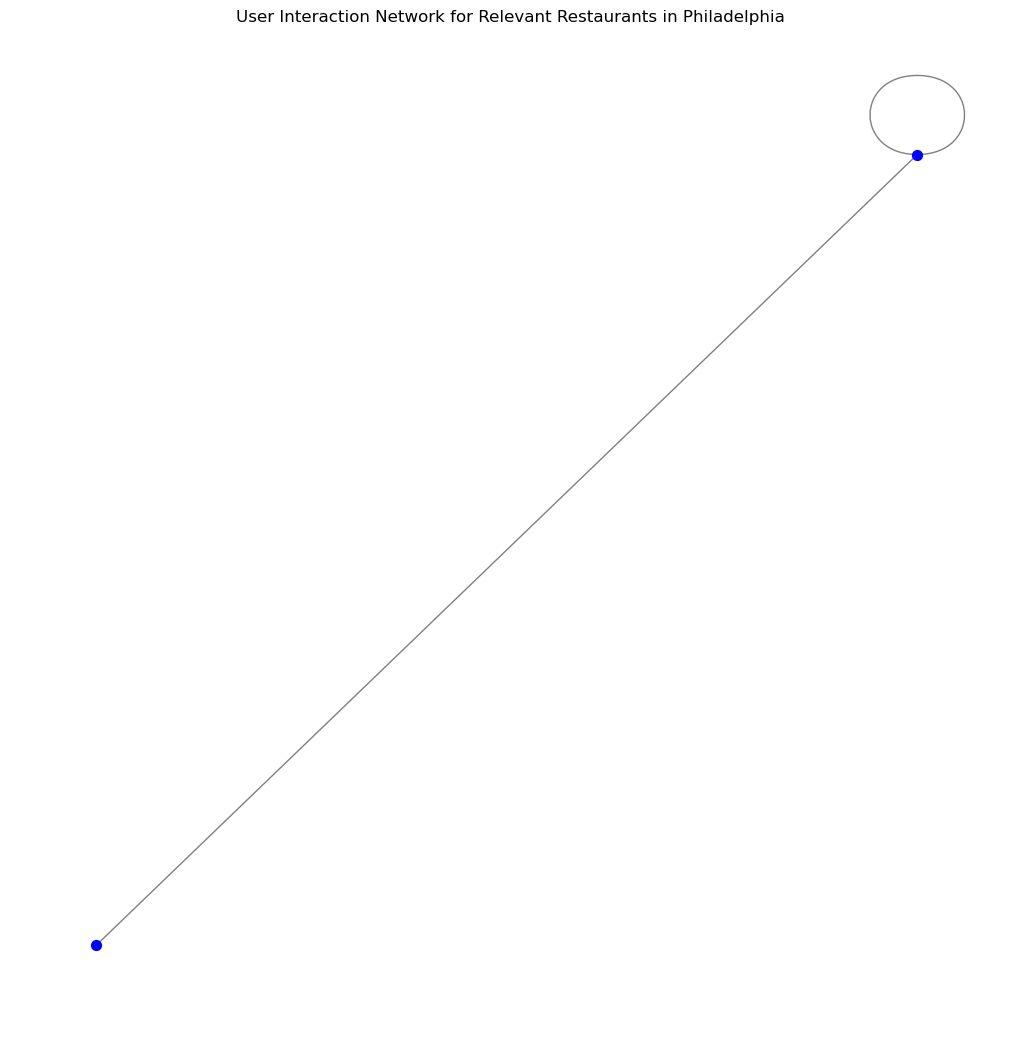

Number of nodes (users): 2
Number of edges (interactions): 2


In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


# Define relevant categories
relevant_categories = [
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
]
set_relevant_categories = set(relevant_categories)

# Filter businesses in Philadelphia
df_business = df_business[df_business['city'] == 'Philadelphia']

# Keep businesses with relevant restaurant categories
df_restaurants = df_business[df_business["categories"].str.contains('Restaurants', na=False)]

# Identify the relevant categories in each restaurant
df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in set_relevant_categories]
)

# Remove businesses that don't belong to any relevant categories
df_restaurants = df_restaurants[df_restaurants['relevant_categories'].apply(len) > 0]

# Step 2: Filter Reviews Based on the Filtered Restaurants

# Merge reviews with the filtered businesses (only for relevant restaurants in Philadelphia)
df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

first_five_users = df_filtered_reviews['user_id'].unique()[:5]
df_filtered_reviews= df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_five_users)]

# Step 3: Create a User Interaction Network

# Initialize a graph
G = nx.Graph()

# Loop through each business and create edges between users who reviewed the same business
for business_id, group in df_filtered_reviews.groupby('business_id'):
    users = group['user_id'].tolist()
    # Add edges between users who reviewed the same business
    for i in range(len(users)):
        for j in range(i+1, len(users)):
            if G.has_edge(users[i], users[j]):
                # Increment weight if edge already exists
                G[users[i]][users[j]]['weight'] += 1
            else:
                # Create edge with weight 1 if it doesn't exist
                G.add_edge(users[i], users[j], weight=1)

# Step 4: Network Analysis and Visualization

# Plot the network (for large networks, you may need to optimize for clarity)
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
plt.show()

# Basic network statistics
print("Number of nodes (users):", G.number_of_nodes())
print("Number of edges (interactions):", G.number_of_edges())

# Optional: find central users or communities in the network


C:\Users\asus\AppData\Local\Temp\ipykernel_20888\4181308348.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


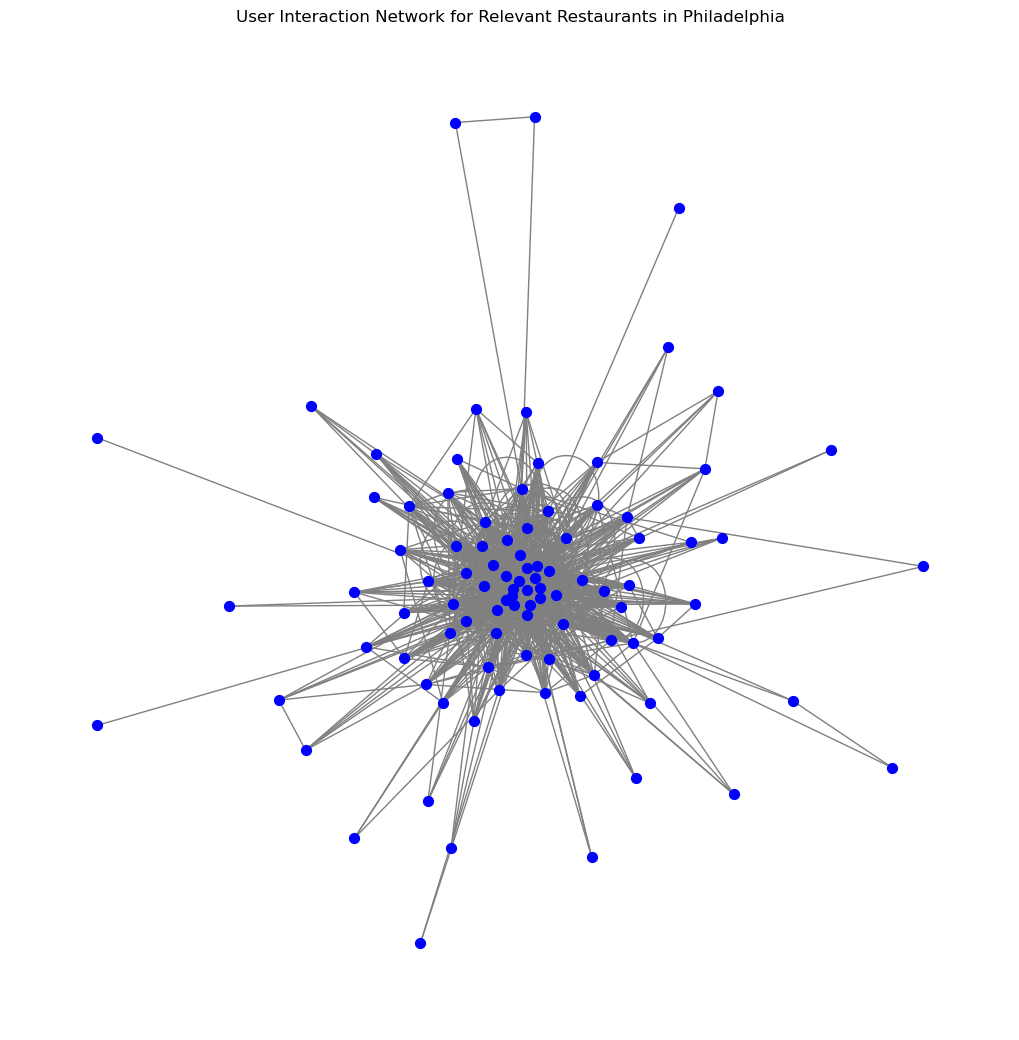

Number of nodes (users): 96
Number of edges (interactions): 1145


In [25]:

from itertools import combinations

# Define relevant categories
relevant_categories = {
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
}

# Filter businesses in Philadelphia and relevant restaurant categories
df_restaurants = df_business[
    (df_business['city'] == 'Philadelphia') & 
    (df_business['categories'].str.contains('Restaurants', na=False))
]

# Identify relevant categories in each restaurant
df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in relevant_categories]
)

# Remove businesses that don't belong to any relevant categories
df_restaurants = df_restaurants[df_restaurants['relevant_categories'].str.len() > 0]

# Merge reviews with the filtered businesses (only for relevant restaurants in Philadelphia)
df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

# Limit to the first five unique users
# first_five_users = df_filtered_reviews['user_id'].unique()[:100]
df_filtered_reviews = df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_five_users)]

# Create a User Interaction Network
G = nx.Graph()

# Loop through each business and create edges between users who reviewed the same business
for business_id, group in df_filtered_reviews.groupby('business_id'):
    users = group['user_id'].tolist()
    # Add edges between users who reviewed the same business using combinations
    for user1, user2 in combinations(users, 2):
        if G.has_edge(user1, user2):
            G[user1][user2]['weight'] += 1
        else:
            G.add_edge(user1, user2, weight=1)

# Network Analysis and Visualization
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
plt.show()

# Basic network statistics
print("Number of nodes (users):", G.number_of_nodes())
print("Number of edges (interactions):", G.number_of_edges())

# Optional: find central users or communities in the network


C:\Users\asus\AppData\Local\Temp\ipykernel_20888\2754700541.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(


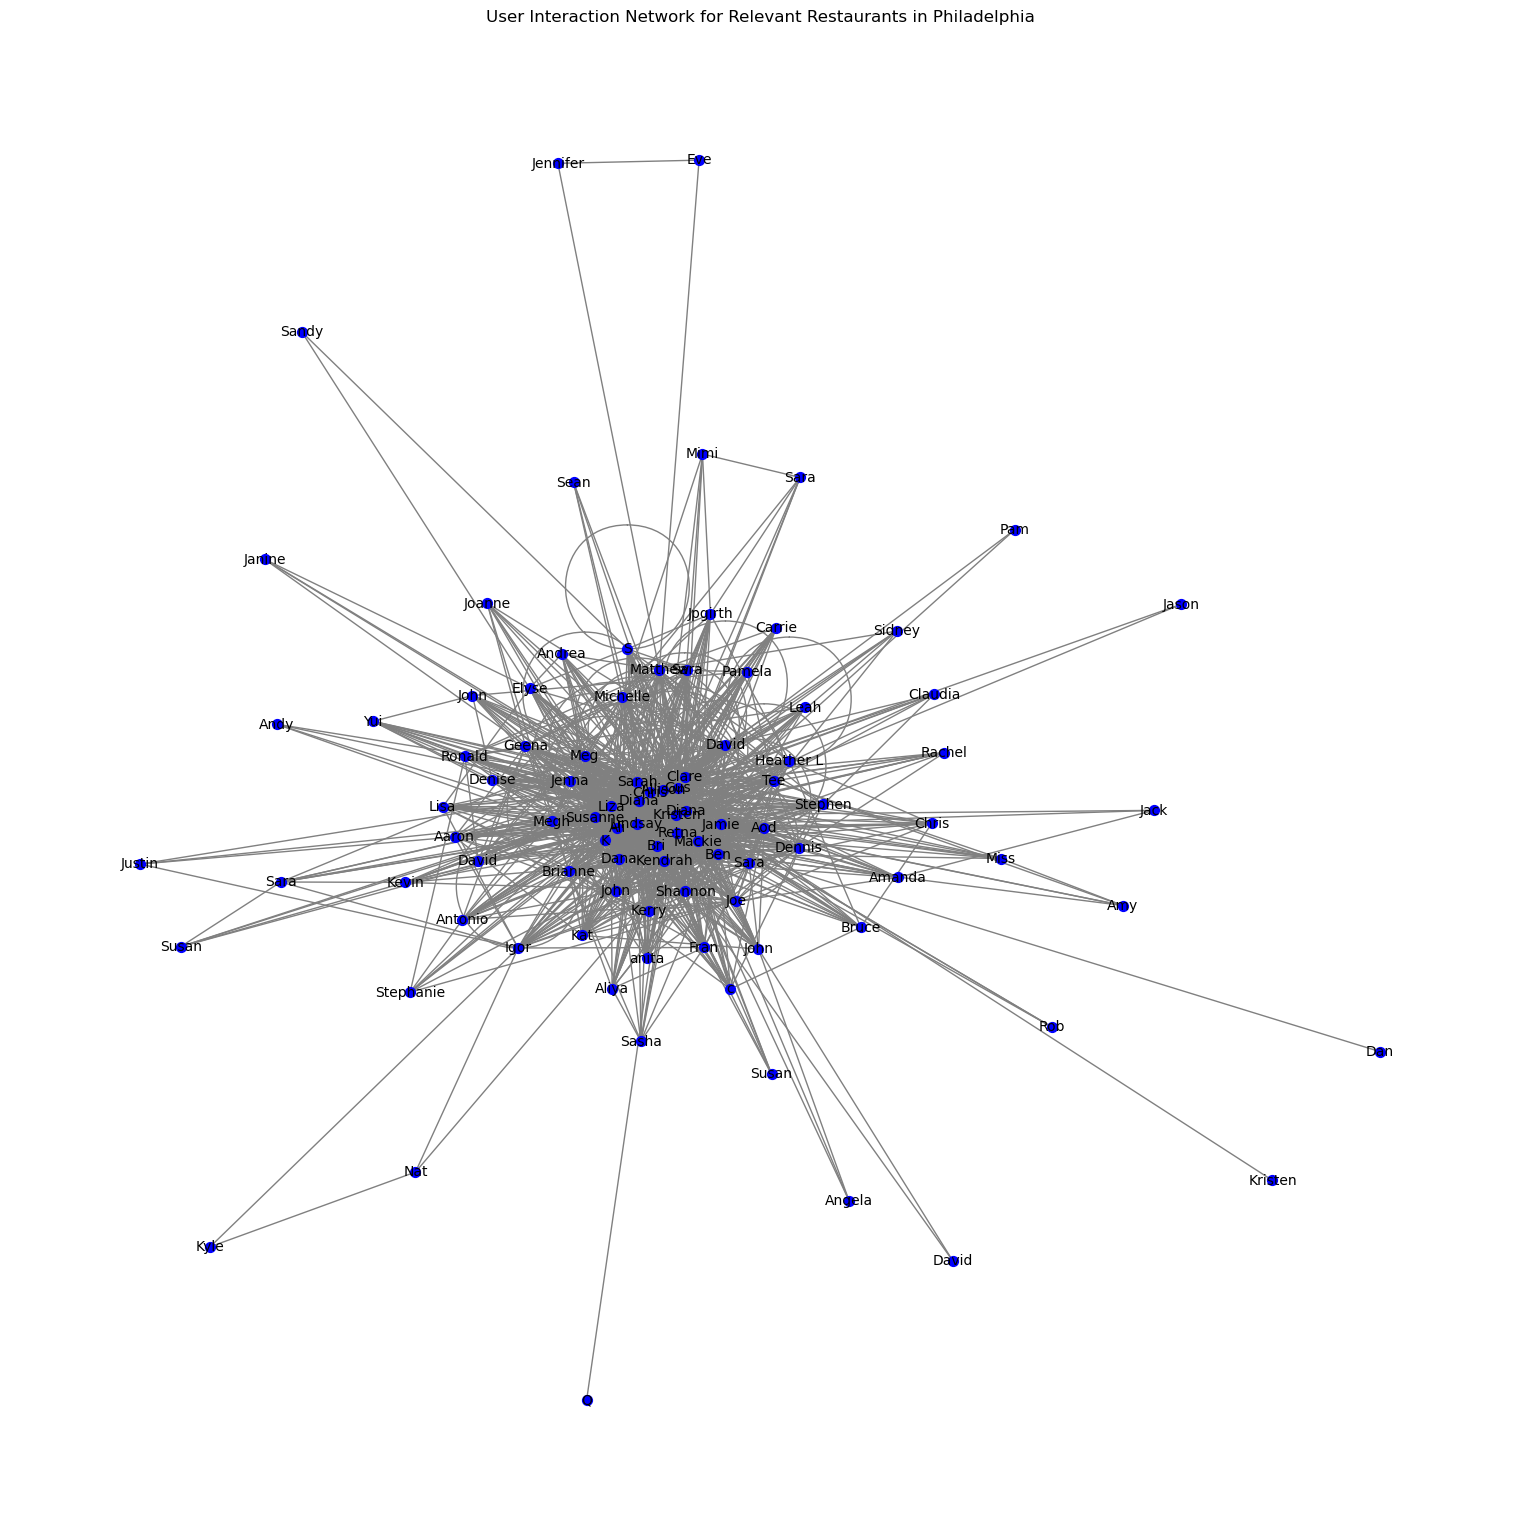

Number of nodes (users): 96
Number of edges (interactions): 1145


In [26]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Define relevant categories
relevant_categories = {
    'American (Traditional)', 'Italian', 'Mexican', 'Chinese', 'Indian', 
    'Japanese', 'Cafes', 'Bakeries', 'Mediterranean', 'Fast Food', 
    'Buffets', 'Food Trucks', 'Bars', 'Pubs', 'Steakhouses', 'Sushi Bars', 
    'Breakfast & Brunch', 'Sandwiches', 'Pizza', 'Seafood', 
    'Cocktail Bars', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 
    'Desserts', 'Barbeque', 'Food Stands', 'Homemade', 'Street Food', 'Bistro', 
    'Sustainable Restaurants'
}

# Filter businesses in Philadelphia and relevant restaurant categories
df_restaurants = df_business[ 
    (df_business['city'] == 'Philadelphia') & 
    (df_business['categories'].str.contains('Restaurants', na=False))
]

# Identify relevant categories in each restaurant
df_restaurants['relevant_categories'] = df_restaurants['categories'].apply(
    lambda x: [cat for cat in x.split(', ') if cat in relevant_categories]
)

# Remove businesses that don't belong to any relevant categories
df_restaurants = df_restaurants[df_restaurants['relevant_categories'].str.len() > 0]

# Merge reviews with the filtered businesses (only for relevant restaurants in Philadelphia)
df_filtered_reviews = pd.merge(df_review, df_restaurants, on='business_id', how='inner')

# Limit to the first five unique users (you can adjust this as needed)
first_five_users = df_filtered_reviews['user_id'].unique()[:100]
df_filtered_reviews = df_filtered_reviews[df_filtered_reviews['user_id'].isin(first_five_users)]

# Create a User Interaction Network
G = nx.Graph()

# Loop through each business and create edges between users who reviewed the same business
for business_id, group in df_filtered_reviews.groupby('business_id'):
    users = group['user_id'].tolist()
    # Add edges between users who reviewed the same business using combinations
    for user1, user2 in combinations(users, 2):
        if G.has_edge(user1, user2):
            G[user1][user2]['weight'] += 1
        else:
            G.add_edge(user1, user2, weight=1)

# Merge user information to get names
df_user_subset = df_user[df_user['user_id'].isin(G.nodes)]
user_names = df_user_subset.set_index('user_id')['name'].to_dict()

# Network Analysis and Visualization
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.1)  # Force-directed layout
nx.draw(G, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, labels=user_names, font_size=10)

plt.title("User Interaction Network for Relevant Restaurants in Philadelphia")
plt.show()

# Basic network statistics
print("Number of nodes (users):", G.number_of_nodes())
print("Number of edges (interactions):", G.number_of_edges())

# Optional: find central users or communities in the network


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming you have already created the user interaction network `G`
# Using the Girvan-Newman algorithm to detect communities
communities_generator = nx.community.girvan_newman(G)
first_community = next(communities_generator)  # Get the first set of communities
first_community = list(first_community)  # Convert to list format

# Print out the detected communities
print("Detected Communities:")
for i, community in enumerate(first_community):
    print(f"Community {i + 1}: {community}")

# Visualize the user interaction network with detected communities
plt.figure(figsize=(15, 10))

# Define distinct colors for communities
community_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Map nodes to community colors
color_map = {}
for idx, community in enumerate(first_community):
    for node in community:
        color_map[node] = community_colors[idx % len(community_colors)]  # Cycle through colors

# Get positions for nodes using spring layout
pos = nx.spring_layout(G, k=0.15, seed=42)  # Adjust k for spacing and seed for reproducibility

# Draw nodes with community colors
nx.draw_networkx_nodes(G, pos, node_color=[color_map[node] for node in G.nodes()], node_size=200, alpha=0.9)

# Draw edges with a consistent color and transparency
nx.draw_networkx_edges(G, pos, edge_color='lightgray', width=1, alpha=0.5)

# Draw labels using the `user_names` dictionary
nx.draw_networkx_labels(G, pos, labels=user_names, font_size=9, font_color='black')

# Title and layout
plt.title('User Interaction Network with Girvan-Newman Communities', fontsize=16)

# Create a legend for the communities
handles = []
for idx, community in enumerate(first_community):
    patch = mpatches.Patch(color=community_colors[idx % len(community_colors)], label=f'Community {idx + 1}')
    handles.append(patch)

# Display the legend
plt.legend(handles=handles, loc='best', title="Communities", fontsize=10)

# Show the final plot
plt.show()


NameError: name 'G' is not defined